In [1]:
# here we're going to just try writing something from scratch
# do single lith for starters

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# set up arrays
dx = 1000
x = np.arange(0, 10000, dx)
x_node = x + (dx/2)

Hstar = 0.5
etab = np.zeros(len(x)) # bedrock elevation, m
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x))
eta = etab + H

In [4]:
# set up parameters
K_ig = np.zeros(len(x))
K_ig[:4] = 1e-7
K_sed = np.zeros(len(x))
K_sed[4:] = 1e-6

beta_ig = np.zeros(len(x))
beta_ig[:4] = 4e-7
beta_sed = np.zeros(len(x))
beta_sed[4:] = 4e-6

# psi = np.zeros(len(x))
# psi[:4] = 4e-7
# psi[4:] = 4e-6
psi = 4e-7
gamma = 0.3

r = 10. # runoff rate
D = 0.015 # grain size
phi = 0.45 # porosity
baselevel_rate = 0.0001 # baselevel fall rate

In [5]:
kqs = 0.041
I = 0.01
kxb = 25
Pxb = 1./5.
kb = 8.3e-8

B_valley = kxb * (x_node**Pxb)
B_basin = (2./3.) * x_node

area = (1./3.) * x**2
# Q = r * x * B
Q = r * area

In [6]:
len(eta)

10

In [7]:
def model(x, dx, x_node,
          K_ig, K_sed, beta_ig, beta_sed,
          D, phi, Hstar, psi, gamma,
          kb, kqs, I, r, B_valley, B_basin, Q,
          etab, H, eta,
          baselevel_rate,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 0.2 * dx * dx / (kqs * q[-1])
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p_ig = np.zeros(len(x))
    Eb_p_sed = np.zeros(len(x))
    Eb_a_ig = np.zeros(len(x))
    Eb_a_sed = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x))
    
    H[-1] = 0
    E[-1] = baselevel_rate
    q[0] = 0
    Qs[0] = 0
    ql[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= baselevel_rate * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc Rh
#         width = (kb * Q[1:] * (S ** (7/6))) / (D**(3/2))
#         depth = (0.09801 * D) / S
#         Rh_efficiency = 1 - np.exp(-width/(2*depth))
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1]) # * Rh_efficiency
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p_ig[:-1] = K_ig[1:] * Q[1:] * S * alpha[:-1]
        Eb_p_sed[:-1] = K_sed[1:] * Q[1:] * S * alpha[:-1]
        Eb_a_ig[:-1] = beta_ig[1:] * Qs[1:] * alpha[:-1]
        Eb_a_sed[:-1] = beta_sed[1:] * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p_ig[:-1] + Eb_p_sed[:-1] + Eb_a_ig[:-1] + Eb_a_sed[:-1]) / B_valley[:-1]
        
        # calc grain attrition
        atr = Qs * psi
        
        # calc equilibrium lateral supply
        # ql[1:] = ((baselevel_rate * gamma) / psi[1:]) * (1 - np.exp(-psi[1:]/(3 * x[1:])))
        ql[1:4] = ((baselevel_rate * gamma) / psi) * (1 - np.exp(-psi/(3 * x[1:4])))
        # ql[:4] = (baselevel_rate * gamma * x[:4]**2)/3
        ql[4:] = 0
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p_ig[:-1] - ql[1:])
        # Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx - Eb_p_ig[:-1] - ql[1:])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p_ig, Eb_p_sed, Eb_a_ig, Eb_a_sed, Eb, atr, ql, Eh, E, etab, H, eta)

In [8]:
#now write a test
num_steps = 1000000
test_run = [x, dx, x_node, 
            K_ig, K_sed, beta_ig, beta_sed, 
            D, phi, Hstar, psi, gamma,
            kb, kqs, I, r, B_valley, B_basin, Q,
            etab, H, eta,
            baselevel_rate,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p_ig, Eb_p_sed, Eb_a_ig, Eb_a_sed, Eb, atr, ql, Eh, E, etab, H, eta) = model(*test_run)

2820769.1083274954


In [9]:
E

array([9.94812617e-05, 9.98627340e-05, 9.99265750e-05, 9.99550566e-05,
       9.99695118e-05, 9.99793412e-05, 9.99865215e-05, 9.99920318e-05,
       9.99964155e-05, 1.00000000e-04])

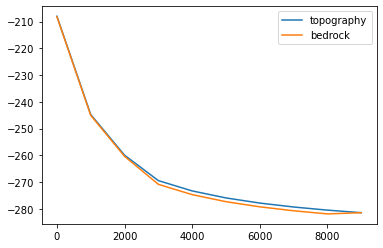

In [10]:
plt.plot(x, eta, label = "topography")
plt.plot(x, etab, label = "bedrock")
plt.legend()

In [11]:
# just for kicks
kb = 8.3e-8
b = (kb * Q[1:] * (S ** (7/6))) / (D**(3/2))
print(b)

[3.19421606 4.55845872 5.93306356 3.67707931 3.67262759 3.66854851
 3.66478836 3.66129071 3.65800882]


In [12]:
# ok really going out on a limb here...
depth = (0.09801 * D) / S
print(depth)

[0.03997166 0.09669738 0.15458809 0.38146127 0.55979994 0.76592423
 0.99846644 1.25632987 1.53860646]


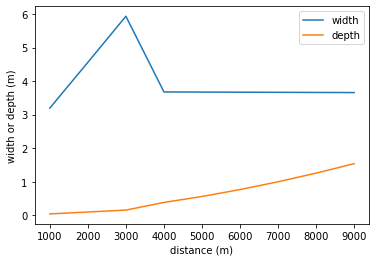

In [13]:
plt.plot(x[1:], b, label = 'width')
plt.plot(x[1:], depth, label = 'depth')
plt.ylabel('width or depth (m)')
plt.xlabel('distance (m)')
plt.legend()

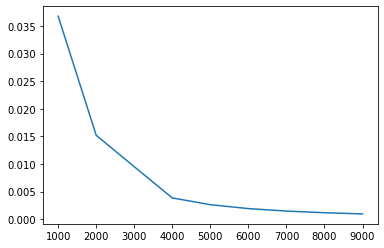

In [14]:
plt.plot(x[1:], S)

In [15]:
S

array([0.03677981, 0.01520362, 0.00951011, 0.003854  , 0.00262621,
       0.00191945, 0.00147241, 0.00117019, 0.00095551])

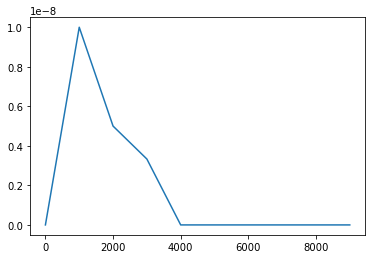

In [16]:
plt.plot(x, ql)

In [17]:
ql

array([0.00000000e+00, 1.00000008e-08, 5.00000041e-09, 3.33333361e-09,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [18]:
small_area = area[3]

In [19]:
S_pred_small = ((baselevel_rate * gamma * area[3])/(kqs * I * Q[-1]))**(6./7.)
print(S_pred_small)

0.002246518009293366


In [20]:
S[4]

0.0026262060740602352

In [21]:
S_pred_array = ((baselevel_rate * gamma * small_area)/(kqs * I * Q[1:]))**(6./7.)

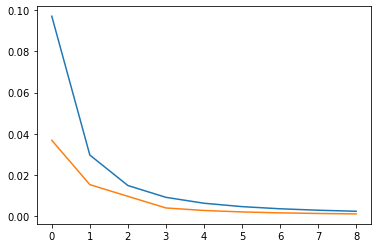

In [22]:
plt.plot(S_pred_array)
plt.plot(S)

In [24]:
difference = S_pred_array - S
print(difference)

[0.06035038 0.01439714 0.00526164 0.00516694 0.00352726 0.0025823
 0.00198392 0.00157897 0.00129101]
